In [36]:
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.applications import imagenet_utils
from keras import applications
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [70]:
mobile = tf.keras.applications.mobilenet_v2.MobileNetV2()
# help(tf.keras.applications.mobilenet_v3())
mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [19]:
# train_path = 'transferdata/Train/'
# valid_path = 'transferdata/Val/'
# test_path = 'transferdata/Test/'

# Test if the model works with 1 example from use folder

In [38]:
def prepare_image(file):
    img_path = './transferdata/Use/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

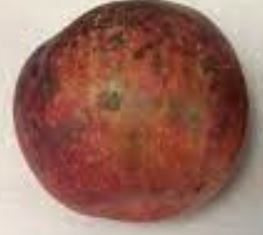

In [39]:
from IPython.display import Image
Image(filename='./transferdata/Use/101.jpg', width=300,height=200) 

In [40]:
preprocessed_image = prepare_image('101.jpg')
predictions = mobile.predict(preprocessed_image)

In [68]:
array = np.array(preprocessed_image)/255.0
array.shape

(1, 224, 224, 3)

In [41]:
results = imagenet_utils.decode_predictions(predictions)

In [42]:
print(results)

[[('n07753113', 'fig', 0.39748955), ('n07768694', 'pomegranate', 0.35167965), ('n03134739', 'croquet_ball', 0.08155053), ('n07745940', 'strawberry', 0.059758745), ('n03720891', 'maraca', 0.014292957)]]


In [69]:
predicted_label_index = np.argmax(results)
predicted_label_index

10

## setup data

In [59]:
train_path = './transferData/Train/'
valid_path = './transferData/Val/'
test_path = './transferData/Test/'
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), class_mode='categorical')
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224),  class_mode='categorical')
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), class_mode='categorical', shuffle=False)

Found 306 images belonging to 4 classes.
Found 76 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [60]:
imageCountTrain = len(train_batches) #10x32 images =320
print (imageCountTrain)
imageCountTest = len(test_batches) # 4x32 images is 128
print (imageCountTest)

10
4


## cut off the last 6 layers

In [44]:
x = mobile.layers[-6].output

## modify to use with 4 layers

In [45]:
output = Dense(units=4,activation='softmax')(x)

In [13]:
model = Model(inputs = mobile.input,outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [46]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [31]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy(from_logits=False)', metrics=['accuracy'])

In [65]:
model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.Accuracy()])

In [66]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=30,
            verbose=2)

Epoch 1/30


ValueError: in user code:

    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 864, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 957, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 459, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/metrics.py", line 178, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/metrics.py", line 729, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/metrics.py", line 3985, in accuracy  **
        y_true.shape.assert_is_compatible_with(y_pred.shape)

    ValueError: Shapes (None, None) and (None, 7, 7, 4) are incompatible
